In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os

from src.proj_utils import(
    tokenize_text,
    create_training_examples,
    prepare_datasets,
    build_vocabulary
)

from src.model import LSTMLangModel, train_model
from src.dataset import TextGenerationDataset, create_dataloaders
from src.evaluate_transformers import evaluate_distilgpt2_rouge

In [2]:
df = pd.read_csv('data/training.1600000.processed.noemoticon_reduced.csv', encoding='latin-1', header=None)
df.columns = ['sentiment', 'id', 'date', 'flag', 'user', 'text']

Блок приведения к нижнему регистру, удаления ссылок, упоминаний через @, спецсимоволов.
После - удалить лишние символы

In [3]:
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace(r'http\S+|www\S+|@\w+|[^\w\s]', '', regex=True)
df['text'] = df['text'].str.strip()

Получение токенов из текста публикаций и обучающих примеров

In [4]:
df['tokenized'] = df['text'].apply(tokenize_text)

In [5]:
X, Y = create_training_examples(df['tokenized'].to_list())

Используется 28 процессов для создания примеров...


Разделение на обучающую проверочную и тестовую выборки

In [6]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_datasets(X, Y)

In [7]:
print(f"Размеры данных:")
print(f"Train: {len(X_train)} примеров")
print(f"Validation: {len(X_val)} примеров")
print(f"Test: {len(X_test)} примеров")

Размеры данных:
Train: 96686 примеров
Validation: 12086 примеров
Test: 12086 примеров


Создать словарь

In [8]:
all_tokens = []
for seq in X:
    all_tokens.extend(seq)
all_tokens.extend(Y)
vocab = build_vocabulary([all_tokens], min_freq=1)
vocab_size = len(vocab)

print(f"Размер словаря: {vocab_size}")
print(f"Примеры слов в словаре: {list(vocab.keys())[:20]}")


test_words = ["this", "is", "a"]
for word in test_words:
    if word in vocab:
        print(f"'{word}' есть в словаре: индекс {vocab[word]}")
    else:
        print(f"'{word}' НЕТ в словаре!")

Размер словаря: 14307
Примеры слов в словаре: ['<PAD>', '<UNK>', 'a', 'thats', 'bummer', 'you', 'shoulda', 'got', 'david', 'carr', 'of', 'third', 'day', 'to', 'do', 'it', 'is', 'upset', 'that', 'he']
'this' есть в словаре: индекс 159
'is' есть в словаре: индекс 16
'a' есть в словаре: индекс 2


Создать загрузчиков данных

In [9]:
batch_size = 64
max_seq_length = 50

train_loader, val_loader, test_loader = create_dataloaders(
        X_train, y_train, X_val, y_val, X_test, y_test,
        vocab, batch_size, max_seq_length
    )

Создать модель

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")

model = LSTMLangModel(
    vocab_size=vocab_size,
    embedding_dim=256,
    hidden_dim=512,
    num_layers=2,
    dropout=0.3
).to(device)
print(f"Количество параметров модели: {sum(p.numel() for p in model.parameters()):,}")

Используемое устройство: cuda
Количество параметров модели: 14,680,291


Обучение модели

In [11]:
train_losses, val_losses, val_rouge_scores = train_model(
        model, train_loader, val_loader, vocab_size, device,
        num_epochs=10, learning_rate=0.001
    )

Эпохи обучения:  10%|█         | 1/10 [00:27<04:08, 27.63s/эпоха, train_loss=7.1143, val_loss=7.0048, rouge1=0.0370, lr=0.001000]

ROUGE Scores: {'rouge1': np.float64(0.037037037037037035), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.037037037037037035), 'rougeLsum': np.float64(0.037037037037037035)}
Эпоха 1/10, Train Loss: 7.1143, Val Loss: 7.0048, ROUGE-1: 0.0370, ROUGE-2: 0.0000, ROUGE-L: 0.0370, LR: 0.001000


Эпохи обучения:  20%|██        | 2/10 [00:55<03:41, 27.71s/эпоха, train_loss=6.9682, val_loss=7.0550, rouge1=0.0476, lr=0.001000]

ROUGE Scores: {'rouge1': np.float64(0.047619047619047616), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.047619047619047616), 'rougeLsum': np.float64(0.047619047619047616)}
Эпоха 2/10, Train Loss: 6.9682, Val Loss: 7.0550, ROUGE-1: 0.0476, ROUGE-2: 0.0000, ROUGE-L: 0.0476, LR: 0.001000


Эпохи обучения:  30%|███       | 3/10 [01:23<03:14, 27.73s/эпоха, train_loss=6.9417, val_loss=7.1304, rouge1=0.0476, lr=0.001000]

ROUGE Scores: {'rouge1': np.float64(0.047619047619047616), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.047619047619047616), 'rougeLsum': np.float64(0.047619047619047616)}
Эпоха 3/10, Train Loss: 6.9417, Val Loss: 7.1304, ROUGE-1: 0.0476, ROUGE-2: 0.0000, ROUGE-L: 0.0476, LR: 0.001000


Эпохи обучения:  40%|████      | 4/10 [01:50<02:46, 27.72s/эпоха, train_loss=6.9292, val_loss=7.1835, rouge1=0.0370, lr=0.000500]

ROUGE Scores: {'rouge1': np.float64(0.037037037037037035), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.037037037037037035), 'rougeLsum': np.float64(0.037037037037037035)}
Эпоха 4/10, Train Loss: 6.9292, Val Loss: 7.1835, ROUGE-1: 0.0370, ROUGE-2: 0.0000, ROUGE-L: 0.0370, LR: 0.000500


Эпохи обучения:  50%|█████     | 5/10 [02:18<02:18, 27.66s/эпоха, train_loss=6.9080, val_loss=7.2115, rouge1=0.0370, lr=0.000500]

ROUGE Scores: {'rouge1': np.float64(0.037037037037037035), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.037037037037037035), 'rougeLsum': np.float64(0.037037037037037035)}
Эпоха 5/10, Train Loss: 6.9080, Val Loss: 7.2115, ROUGE-1: 0.0370, ROUGE-2: 0.0000, ROUGE-L: 0.0370, LR: 0.000500


Эпохи обучения:  60%|██████    | 6/10 [02:46<01:50, 27.69s/эпоха, train_loss=6.9046, val_loss=7.2532, rouge1=0.0370, lr=0.000500]

ROUGE Scores: {'rouge1': np.float64(0.037037037037037035), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.037037037037037035), 'rougeLsum': np.float64(0.037037037037037035)}
Эпоха 6/10, Train Loss: 6.9046, Val Loss: 7.2532, ROUGE-1: 0.0370, ROUGE-2: 0.0000, ROUGE-L: 0.0370, LR: 0.000500


Эпохи обучения:  70%|███████   | 7/10 [03:13<01:23, 27.70s/эпоха, train_loss=6.9017, val_loss=7.3009, rouge1=0.0370, lr=0.000250]

ROUGE Scores: {'rouge1': np.float64(0.037037037037037035), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.037037037037037035), 'rougeLsum': np.float64(0.037037037037037035)}
Эпоха 7/10, Train Loss: 6.9017, Val Loss: 7.3009, ROUGE-1: 0.0370, ROUGE-2: 0.0000, ROUGE-L: 0.0370, LR: 0.000250


Эпохи обучения:  80%|████████  | 8/10 [03:41<00:55, 27.69s/эпоха, train_loss=6.8929, val_loss=7.3190, rouge1=0.0476, lr=0.000250]

ROUGE Scores: {'rouge1': np.float64(0.047619047619047616), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.047619047619047616), 'rougeLsum': np.float64(0.047619047619047616)}
Эпоха 8/10, Train Loss: 6.8929, Val Loss: 7.3190, ROUGE-1: 0.0476, ROUGE-2: 0.0000, ROUGE-L: 0.0476, LR: 0.000250


Эпохи обучения:  90%|█████████ | 9/10 [04:09<00:27, 27.72s/эпоха, train_loss=6.8917, val_loss=7.3425, rouge1=0.0370, lr=0.000250]

ROUGE Scores: {'rouge1': np.float64(0.037037037037037035), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.037037037037037035), 'rougeLsum': np.float64(0.037037037037037035)}
Эпоха 9/10, Train Loss: 6.8917, Val Loss: 7.3425, ROUGE-1: 0.0370, ROUGE-2: 0.0000, ROUGE-L: 0.0370, LR: 0.000250


Эпохи обучения: 100%|██████████| 10/10 [04:37<00:00, 27.71s/эпоха, train_loss=6.8907, val_loss=7.3624, rouge1=0.0370, lr=0.000125]

ROUGE Scores: {'rouge1': np.float64(0.037037037037037035), 'rouge2': np.float64(0.0), 'rougeL': np.float64(0.037037037037037035), 'rougeLsum': np.float64(0.037037037037037035)}
Эпоха 10/10, Train Loss: 6.8907, Val Loss: 7.3624, ROUGE-1: 0.0370, ROUGE-2: 0.0000, ROUGE-L: 0.0370, LR: 0.000125


Визуализация результатов

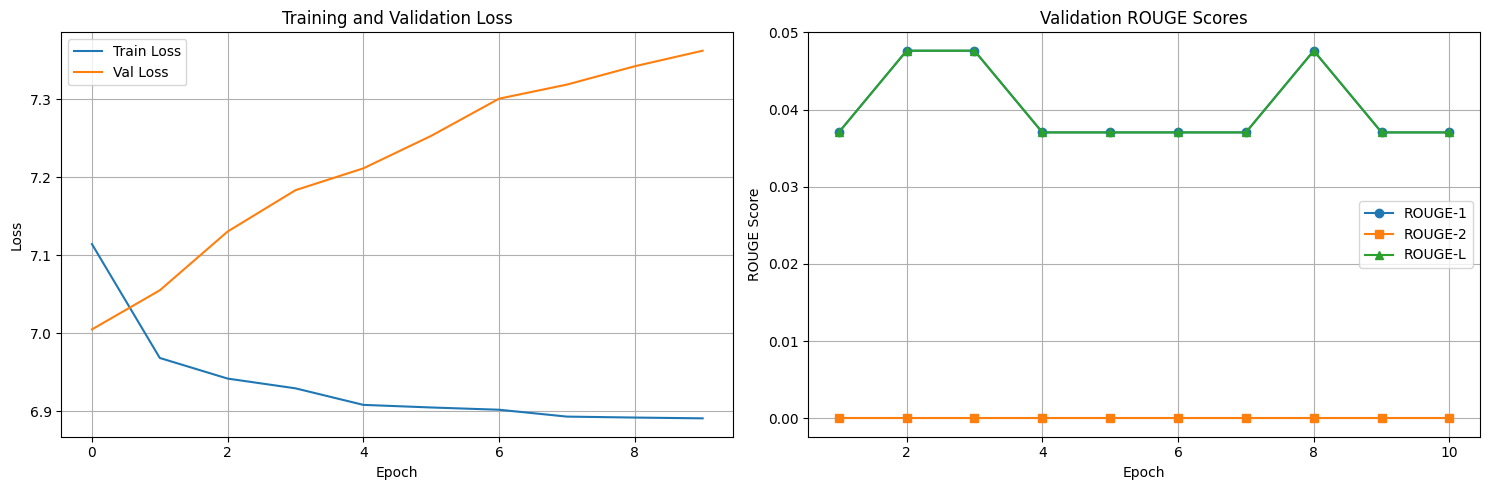


Финальные метрики:
Final Train Loss: 6.8907
Final Val Loss: 7.3624
Final ROUGE-1: 0.0370
Final ROUGE-2: 0.0000
Final ROUGE-L: 0.0370


In [12]:
plt.figure(figsize=(15,5))

#Потери
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

#Rouge метрики
plt.subplot(1, 2, 2)
rouge1_scores = [score.get('rouge1', 0) for score in val_rouge_scores if score]
rouge2_scores = [score.get('rouge2', 0) for score in val_rouge_scores if score]
rougeL_scores = [score.get('rougeL', 0) for score in val_rouge_scores if score]

epochs = range(1, len(rouge1_scores) + 1)
plt.plot(epochs, rouge1_scores, label='ROUGE-1', marker='o')
plt.plot(epochs, rouge2_scores, label='ROUGE-2', marker='s')
plt.plot(epochs, rougeL_scores, label='ROUGE-L', marker='^')
plt.xlabel('Epoch')
plt.ylabel('ROUGE Score')
plt.title('Validation ROUGE Scores')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics.png')
plt.show()

print("\nФинальные метрики:")
print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Val Loss: {val_losses[-1]:.4f}")
if val_rouge_scores and val_rouge_scores[-1]:
    print(f"Final ROUGE-1: {val_rouge_scores[-1]['rouge1']:.4f}")
    print(f"Final ROUGE-2: {val_rouge_scores[-1]['rouge2']:.4f}")
    print(f"Final ROUGE-L: {val_rouge_scores[-1]['rougeL']:.4f}")

Тестирование модели

In [13]:
model.eval()
test_loss = 0
criterion = nn.CrossEntropyLoss(ignore_index=0)

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        targets = batch['target'].to(device)
        
        outputs, _ = model(input_ids)
        loss = criterion(outputs, targets)
        
        test_loss += loss.item()

avg_test_loss = test_loss / len(test_loader)
print(f"Значение потери на этапе тестирования: {avg_test_loss:.4f}")

Значение потери на этапе тестирования: 7.4016


Пример предсказания

In [14]:
test_sequence = ["this", "is", "a"]
next_token, probabilities = model.predict_next_token(test_sequence, vocab, device)
print(f"Input: {' '.join(test_sequence)}")
print(f"Predicted next token: {next_token}")

Топ-5 предсказаний:
  1. 'to' (13): 0.0545
  2. 'i' (34): 0.0544
  3. 'the' (39): 0.0407
  4. 'a' (2): 0.0287
  5. 'my' (47): 0.0235
Input: this is a
Predicted next token: to


Оценка с использованием distilgpt2

In [15]:
val_texts = []
for i, (x_seq, y_token) in enumerate(zip(X_val, y_val)):
    if i < 100:  # Ограничение количества для скорости
        text = ' '.join(x_seq) + ' ' + y_token
        val_texts.append(text)

gpt2_results = evaluate_distilgpt2_rouge(val_texts[:50])
print("\nСравнение моделей:")
print(f"LSTM ROUGE-1: {val_rouge_scores[-1]['rouge1']:.4f}")
print(f"DistilGPT2 ROUGE-1: {gpt2_results['rouge1']:.4f}")


Загрузка модели DistilGPT2...


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

d:\ML\Yandex\Projects\text-autocomplete\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\a.ledenev\.cache\huggingface\hub\models--distilgpt2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


Начинаем оценку модели...


Оценка текстов:   0%|          | 0/50 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Both `max_new_tokens` (=256) and `max_length`(=31) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Оценка текстов:  34%|███▍      | 17/50 [00:03<00:04,  7.28it/s]Both `max_new_tokens` (=256) and `max_length`(=18) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_ne


РЕЗУЛЬТАТЫ ОЦЕНКИ DistilGPT2
ROUGE-1: 0.0023
ROUGE-2: 0.0000
ROUGE-L: 0.0020
Оценено текстов: 20

Примеры предсказаний:

Пример 1:
Контекст: ['lol', 'yea', 'i', 'really', 'hated', 'that', 'episode', 'last', 'night', 'and', 'i', 'hated', 'the', 'fake', 'obit']...
Ожидалось: online even more im gonna miss
Предсказано: uary because i thought i could not watch it, i just watched it, i dont like it in the first place, it is a ridiculous thing to watch it i dont like it in the first place, it is a ridiculous thing to watch it i dont like it in the first place, it is a ridiculous thing to watch it i dont like it in the first place, it is a ridiculous thing to watch it i dont like it in the first place, it is a ridiculous thing to watch it i dont like it in the first place, it is a ridiculous thing to watch it i dont like it in the first place, it is a ridiculous thing to watch it i dont like it in the first place, it is a ridiculous thing to watch it i dont like it in the first place, it is 

Сохранение модели

In [ ]:
save_path = "models/lstm_language_model.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save({
        'model_state_dict': model.state_dict(),
        'vocab': vocab,
        'model_config': {
            'vocab_size': vocab_size,
            'embedding_dim': 256,
            'hidden_dim': 512,
            'num_layers': 2,
            'dropout': 0.3
        }
    }, save_path)
print(f"Модель сохранена в: {save_path}")

# Вывод

Исходя из наблюдающегося чрезмерно большого времени на обучение нейросети было принято решение урезать с 1,6М записей до 10К записей в исходном .csv файле, подаваемого на вход. Даже при таком кардинальном уменьшении обучающей выборки результат на основе LSTM превосходит DistilGPT2:

LSTM ROUGE-1: <b>0.0370</b><br>
DistilGPT2 ROUGE-1: <b>0.0023</b>
